In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glaucoma-detection/glaucoma.csv
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/537.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/521.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/539.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/501.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/544.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/489.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/576.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/503.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


# Prepare Glaucoma Dataset

In [3]:
class FullGlaucomaDataset(Dataset):
    def __init__(self, fundus_dir, origa_mat, origa_img_dir, acrima_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        # Fundus dataset
        for label_dir in ["Glaucoma_Negative", "Glaucoma_Positive"]:
            full_dir = os.path.join(fundus_dir, "Train", label_dir)
            label = 0 if "Negative" in label_dir else 1
            for f in glob.glob(full_dir + "/*.jpg"):
                self.samples.append((f,label))
        
        # ORIGA dataset
        import scipy.io
        origa_data = scipy.io.loadmat(origa_mat)['Origa']
        for i in range(len(origa_data[0])):
            fname = origa_data[0][i]['Filename'][0]
            label = int(origa_data[0][i]['Glaucoma'][0][0])
            img_path = os.path.join(origa_img_dir, fname)
            if os.path.exists(img_path):
                self.samples.append((img_path, label))
        
        # ACRIMA dataset
        for f in glob.glob(acrima_dir + "/*.jpg"):
            fname = os.path.basename(f)
            label = 1 if "_g_" in fname else 0
            self.samples.append((f,label))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")  # 3 channels
        if self.transform:
            img = self.transform(img)
        return img, label


# Train/Validatin Split

In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms

# ==================== MINIMAL AUGMENTATION (GLAUCOMA-SAFE) ====================

# Training transforms - MINIMAL augmentation to preserve glaucoma patterns
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Fixed size, no random crop
    transforms.RandomHorizontalFlip(p=0.3),  # Very conservative (eyes can be mirrored)
    # NO rotation - can distort optic disc shape
    # NO color jitter - can affect vessel/disc appearance
    # NO vertical flip - not anatomically correct for fundus
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transforms - ABSOLUTELY NO augmentation
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ==================== DATASET PATHS ====================

fundus_dir = "/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted"
origa_mat = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/OrigaList.mat"
origa_img_dir = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images"
acrima_dir = "/kaggle/input/glaucoma-detection/ACRIMA/Images"

# ==================== CREATE FULL DATASET ====================

full_dataset = FullGlaucomaDataset(
    fundus_dir=fundus_dir,
    origa_mat=origa_mat,
    origa_img_dir=origa_img_dir,
    acrima_dir=acrima_dir,
    transform=transform_train
)

print("="*80)
print("🔬 IMPROVED CNN-ViT HYBRID - MINIMAL AUGMENTATION")
print("="*80)
print(f"Total samples: {len(full_dataset)}")

# ==================== ANALYZE CLASS DISTRIBUTION ====================

all_labels = []
for i in range(len(full_dataset)):
    _, label = full_dataset[i]
    all_labels.append(label)

all_labels = np.array(all_labels)
unique_labels, counts = np.unique(all_labels, return_counts=True)

print(f"\n📊 Class Distribution:")
print(f"   Healthy (0): {counts[0]} samples ({counts[0]/len(all_labels)*100:.1f}%)")
print(f"   Glaucoma (1): {counts[1]} samples ({counts[1]/len(all_labels)*100:.1f}%)")

imbalance_ratio = max(counts) / min(counts)
if imbalance_ratio > 2:
    print(f"\n⚠️  Class imbalance detected (ratio: {imbalance_ratio:.2f}:1)")
else:
    print(f"\n✅ Classes balanced (ratio: {imbalance_ratio:.2f}:1)")

# ==================== STRATIFIED TRAIN/VAL SPLIT ====================

def stratified_split(dataset, labels, train_ratio=0.8, random_seed=42):
    """Stratified split to maintain class distribution"""
    np.random.seed(random_seed)
    
    indices = np.arange(len(dataset))
    train_indices = []
    val_indices = []
    
    for class_label in np.unique(labels):
        class_indices = indices[labels == class_label]
        np.random.shuffle(class_indices)
        
        split_point = int(len(class_indices) * train_ratio)
        train_indices.extend(class_indices[:split_point])
        val_indices.extend(class_indices[split_point:])
    
    return train_indices, val_indices

train_indices, val_indices = stratified_split(full_dataset, all_labels, train_ratio=0.8)

print(f"\n📂 Stratified Split:")
print(f"   Train samples: {len(train_indices)}")
print(f"   Validation samples: {len(val_indices)}")

train_labels = all_labels[train_indices]
val_labels = all_labels[val_indices]

train_healthy = np.sum(train_labels == 0)
train_glaucoma = np.sum(train_labels == 1)
val_healthy = np.sum(val_labels == 0)
val_glaucoma = np.sum(val_labels == 1)

print(f"\n   Train → Healthy: {train_healthy}, Glaucoma: {train_glaucoma}")
print(f"   Val   → Healthy: {val_healthy}, Glaucoma: {val_glaucoma}")

# ==================== TRANSFORM SUBSET ====================

class TransformSubset(torch.utils.data.Dataset):
    """Subset with custom transform"""
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
        self.original_transform = dataset.transform
    
    def __getitem__(self, idx):
        self.dataset.transform = self.transform
        data, label = self.dataset[self.indices[idx]]
        self.dataset.transform = self.original_transform
        return data, label
    
    def __len__(self):
        return len(self.indices)

train_dataset = TransformSubset(full_dataset, train_indices, transform=transform_train)
val_dataset = TransformSubset(full_dataset, val_indices, transform=transform_val)

# ==================== WEIGHTED SAMPLER ====================

def get_weighted_sampler(labels):
    """Simple weighted sampler"""
    class_counts = np.bincount(labels)
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[labels]
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    return sampler

train_sampler = get_weighted_sampler(train_labels)

print(f"\n⚖️  Using weighted sampling")

# ==================== CLASS WEIGHTS FOR LOSS ====================

class_counts = np.bincount(train_labels)
total_samples = len(train_labels)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights = torch.FloatTensor(class_weights)

print(f"\n🎯 Class Weights for Loss Function:")
print(f"   Healthy: {class_weights[0]:.4f}")
print(f"   Glaucoma: {class_weights[1]:.4f}")

# ==================== DATA LOADERS ====================

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=train_sampler,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"\n✅ Data Loaders Created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Batch size: 32")
print(f"   Image size: 224×224")

# ==================== VERIFY LOADER ====================

print(f"\n🔍 Verifying Data Loader...")

try:
    train_batch = next(iter(train_loader))
    images, labels = train_batch
    
    print(f"   ✅ Train batch shape: {images.shape}")
    print(f"   ✅ Labels shape: {labels.shape}")
    print(f"   ✅ Image range: [{images.min():.2f}, {images.max():.2f}]")
    
    unique_batch, counts_batch = np.unique(labels.numpy(), return_counts=True)
    healthy_count = counts_batch[0] if 0 in unique_batch else 0
    glaucoma_count = counts_batch[1] if 1 in unique_batch else 0
    print(f"   ✅ Batch balance: Healthy={healthy_count}, Glaucoma={glaucoma_count}")
    
except Exception as e:
    print(f"   ❌ Error loading batch: {e}")

# ==================== ANALYZE BATCHES ====================

def analyze_batches(loader, num_batches=10, name="Train"):
    """Analyze class distribution across batches"""
    print(f"\n📊 Analyzing {name} Batches:")
    glaucoma_counts = []
    
    for i, (images, labels) in enumerate(loader):
        if i >= num_batches:
            break
        glaucoma_count = (labels == 1).sum().item()
        glaucoma_counts.append(glaucoma_count)
    
    avg_glaucoma = np.mean(glaucoma_counts)
    std_glaucoma = np.std(glaucoma_counts)
    
    print(f"   Average glaucoma/batch: {avg_glaucoma:.1f} ± {std_glaucoma:.1f}")
    print(f"   Expected for balance: ~{32//2:.0f}")
    
    if abs(avg_glaucoma - 16) < 5:
        print(f"   ✅ Batches are well-balanced!")
    else:
        print(f"   ⚠️  Check weighted sampler")

analyze_batches(train_loader, num_batches=10, name="Train")

# ==================== SUMMARY ====================

print("\n" + "="*80)
print("📋 DATA PIPELINE SUMMARY")
print("="*80)
print(f"✅ Total samples: {len(full_dataset)}")
print(f"✅ Training samples: {len(train_dataset)}")
print(f"✅ Validation samples: {len(val_dataset)}")
print(f"✅ Image resolution: 224×224")
print(f"✅ Batch size: 32")
print(f"✅ Stratified split: Yes")
print(f"✅ Weighted sampling: Yes")
print(f"✅ Class weights: Calculated")
print("="*80)

print("\n⚕️  Augmentation Strategy (Glaucoma-Safe):")
print("   Training:")
print("     • Resize to 224×224 (no crop)")
print("     • Horizontal flip: 30% (conservative)")
print("     • NO rotation (preserves optic disc shape)")
print("     • NO color jitter (preserves vessel appearance)")
print("     • NO vertical flip (anatomically incorrect)")
print("   Validation:")
print("     • Resize only (zero augmentation)")

print("\n💡 Why Minimal Augmentation?")
print("   • Optic disc shape is critical for glaucoma diagnosis")
print("   • Vessel patterns must be preserved")
print("   • Cup-to-disc ratio is key diagnostic feature")
print("   • Excessive augmentation can mask pathology")

print("\n" + "="*80)
print("🚀 Ready for training with glaucoma-safe augmentation!")
print("="*80)

🔬 IMPROVED CNN-ViT HYBRID - MINIMAL AUGMENTATION
Total samples: 1873

📊 Class Distribution:
   Healthy (0): 1177 samples (62.8%)
   Glaucoma (1): 696 samples (37.2%)

✅ Classes balanced (ratio: 1.69:1)

📂 Stratified Split:
   Train samples: 1497
   Validation samples: 376

   Train → Healthy: 941, Glaucoma: 556
   Val   → Healthy: 236, Glaucoma: 140

⚖️  Using weighted sampling

🎯 Class Weights for Loss Function:
   Healthy: 0.7954
   Glaucoma: 1.3462

✅ Data Loaders Created:
   Train batches: 46
   Val batches: 12
   Batch size: 32
   Image size: 224×224

🔍 Verifying Data Loader...
   ✅ Train batch shape: torch.Size([32, 3, 224, 224])
   ✅ Labels shape: torch.Size([32])
   ✅ Image range: [-2.12, 2.57]
   ✅ Batch balance: Healthy=18, Glaucoma=14

📊 Analyzing Train Batches:
   Average glaucoma/batch: 15.9 ± 2.3
   Expected for balance: ~16
   ✅ Batches are well-balanced!

📋 DATA PIPELINE SUMMARY
✅ Total samples: 1873
✅ Training samples: 1497
✅ Validation samples: 376
✅ Image resolution:

# Visualize Some Images

Training set samples:


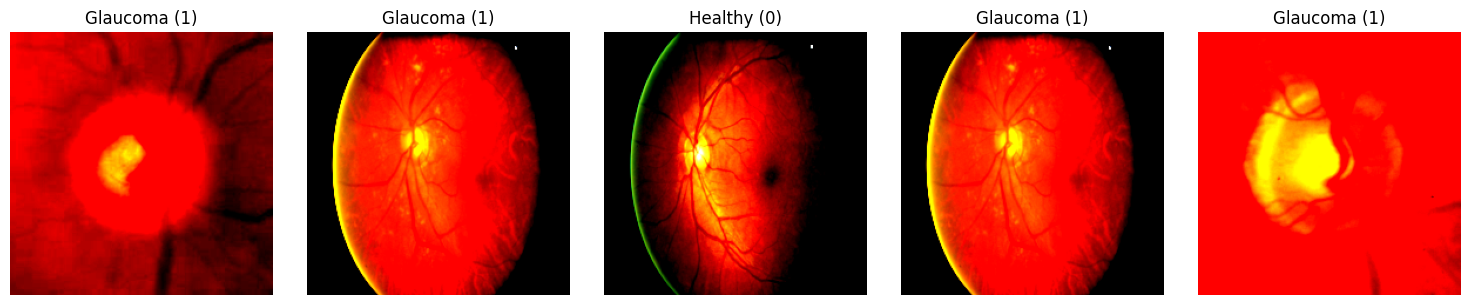

Validation set samples:


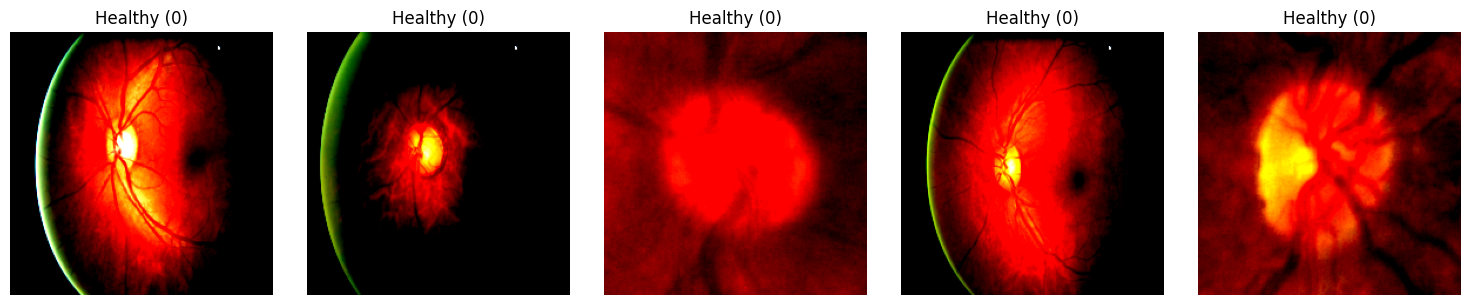

In [5]:
import matplotlib.pyplot as plt
import torch

# Label mapping
classes = ['Healthy (0)', 'Glaucoma (1)']

def show_samples(loader, num_samples=5):
    """
    Display sample RGB images from a DataLoader in a grid.
    """
    images, labels = next(iter(loader))  # get one batch
    num_samples = min(num_samples, len(images))
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).cpu()  # (C, H, W) -> (H, W, C)
        label = labels[i].item()
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show samples from training and validation sets
print("Training set samples:")
show_samples(train_loader, num_samples=5)

print("Validation set samples:")
show_samples(val_loader, num_samples=5)


# CNN and ViT Hybrid Model

In [6]:
"""
Improved CNN-ViT Hybrid Model for Glaucoma Detection
Fixed version with correct tensor dimensions for DataParallel

Key improvements:
- Fixed positional embedding size issue
- 224×224 input optimized
- Lighter architecture
- Medical imaging focused
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# ==================== EFFICIENT CNN BACKBONE ====================

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ConvBlock(nn.Module):
    """Efficient Convolutional Block with residual"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.conv(x)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class LightweightCNN(nn.Module):
    """Lightweight CNN backbone for 224×224 images"""
    def __init__(self, in_channels=3):
        super(LightweightCNN, self).__init__()
        
        # Stem: 224 -> 56
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 64, 7, 2, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)
        )
        
        # Stage 1: 56 -> 28
        self.stage1 = nn.Sequential(
            ConvBlock(64, 128, stride=2),
            ConvBlock(128, 128),
        )
        
        # Stage 2: 28 -> 14
        self.stage2 = nn.Sequential(
            ConvBlock(128, 256, stride=2),
            ConvBlock(256, 256),
            SEBlock(256)
        )
        
        # Stage 3: 14 -> 7
        self.stage3 = nn.Sequential(
            ConvBlock(256, 512, stride=2),
            ConvBlock(512, 512),
            SEBlock(512)
        )
        
    def forward(self, x):
        x = self.stem(x)     # [B, 64, 56, 56]
        s1 = self.stage1(x)  # [B, 128, 28, 28]
        s2 = self.stage2(s1) # [B, 256, 14, 14]
        s3 = self.stage3(s2) # [B, 512, 7, 7]
        return s1, s2, s3

# ==================== VISION TRANSFORMER COMPONENTS ====================

class PatchEmbed(nn.Module):
    """Patch Embedding for 224×224 images"""
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=512):
        super(PatchEmbed, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2  # 14×14 = 196
        
        self.proj = nn.Conv2d(in_channels, embed_dim, patch_size, patch_size)
        
    def forward(self, x):
        B, C, H, W = x.shape
        # Project patches
        x = self.proj(x)  # [B, embed_dim, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        return x

class Attention(nn.Module):
    """Multi-Head Self-Attention"""
    def __init__(self, dim, num_heads=8, dropout=0.1):
        super(Attention, self).__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class MLP(nn.Module):
    """MLP block"""
    def __init__(self, in_features, hidden_features=None, dropout=0.1):
        super(MLP, self).__init__()
        hidden_features = hidden_features or in_features * 4
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.drop1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop2 = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

class TransformerBlock(nn.Module):
    """Transformer Encoder Block"""
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), dropout)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# ==================== MAIN HYBRID MODEL ====================

class ImprovedCNNViTHybrid(nn.Module):
    """
    Improved CNN-ViT Hybrid - Fixed for DataParallel
    Optimized for 224×224 glaucoma fundus images
    """
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_channels=3,
        num_classes=2,
        embed_dim=512,
        depth=6,
        num_heads=8,
        mlp_ratio=4.0,
        dropout=0.3
    ):
        super(ImprovedCNNViTHybrid, self).__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        
        # CNN backbone
        self.cnn = LightweightCNN(in_channels)
        
        # Patch embedding
        self.patch_embed = PatchEmbed(img_size, patch_size, in_channels, embed_dim)
        self.num_patches = self.patch_embed.num_patches
        
        # CLS token and positional embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # FIXED: Correctly sized positional embedding (num_patches + 1 for cls token)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # CNN feature projection
        self.cnn_proj = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, embed_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        
        # Classification head
        self.head = nn.Sequential(
            nn.Linear(embed_dim * 2, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        # Initialize positional embeddings
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
        # Initialize other layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    
    def forward(self, x):
        B = x.shape[0]
        
        # CNN path
        _, _, cnn_features = self.cnn(x)  # [B, 512, 7, 7]
        cnn_global = self.cnn_proj(cnn_features)  # [B, embed_dim]
        
        # ViT path
        x = self.patch_embed(x)  # [B, num_patches, embed_dim]
        
        # Add cls token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat([cls_tokens, x], dim=1)  # [B, num_patches+1, embed_dim]
        
        # Add positional embedding (dimensions now match!)
        x = x + self.pos_embed  # Both are [B, num_patches+1, embed_dim]
        x = self.pos_drop(x)
        
        # Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        
        x = self.norm(x)
        cls_token_out = x[:, 0]  # [B, embed_dim]
        
        # Fuse CNN and ViT features
        fused = torch.cat([cls_token_out, cnn_global], dim=1)  # [B, embed_dim*2]
        
        # Classification
        logits = self.head(fused)
        
        return logits
    
    def get_num_params(self):
        """Count model parameters"""
        return sum(p.numel() for p in self.parameters())

# ==================== MODEL VARIANTS ====================

def ImprovedHybrid_Tiny(num_classes=2):
    """Tiny variant - fastest (4 layers)"""
    return ImprovedCNNViTHybrid(
        img_size=224,
        patch_size=16,
        num_classes=num_classes,
        embed_dim=384,
        depth=4,
        num_heads=6,
        mlp_ratio=4.0,
        dropout=0.2
    )

def ImprovedHybrid_Small(num_classes=2):
    """Small variant - RECOMMENDED (6 layers)"""
    return ImprovedCNNViTHybrid(
        img_size=224,
        patch_size=16,
        num_classes=num_classes,
        embed_dim=512,
        depth=6,
        num_heads=8,
        mlp_ratio=4.0,
        dropout=0.3
    )

def ImprovedHybrid_Base(num_classes=2):
    """Base variant - maximum performance (8 layers)"""
    return ImprovedCNNViTHybrid(
        img_size=224,
        patch_size=16,
        num_classes=num_classes,
        embed_dim=512,
        depth=8,
        num_heads=8,
        mlp_ratio=4.0,
        dropout=0.3
    )

# ==================== EXAMPLE USAGE ====================

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print("="*80)
    print("🔬 Improved CNN-ViT Hybrid Model (FIXED)")
    print("="*80)
    
    # Create model
    model = ImprovedHybrid_Small(num_classes=2).to(device)
    
    # Count parameters
    total_params = model.get_num_params()
    
    print(f"\n📊 Model Statistics:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Model size: ~{total_params * 4 / 1024**2:.1f} MB")
    
    # Test forward pass
    print(f"\n🧪 Testing forward pass...")
    model.eval()
    
    # Test single image
    with torch.no_grad():
        dummy_input = torch.randn(2, 3, 224, 224).to(device)
        print(f"   Input shape: {dummy_input.shape}")
        output = model(dummy_input)
        print(f"   ✅ Output shape: {output.shape}")
        print(f"   ✅ Output range: [{output.min():.3f}, {output.max():.3f}]")
    
    # Test with DataParallel (simulate multi-GPU)
    if torch.cuda.device_count() > 1:
        print(f"\n🔥 Testing with DataParallel ({torch.cuda.device_count()} GPUs)...")
        model_parallel = nn.DataParallel(model)
        with torch.no_grad():
            output_parallel = model_parallel(dummy_input)
            print(f"   ✅ DataParallel output shape: {output_parallel.shape}")
    
    print("\n" + "="*80)
    print("🏗️  Architecture Overview:")
    print("="*80)
    print(f"   Input: 224×224 RGB images")
    print(f"   CNN Backbone: 3-stage feature extraction")
    print(f"   Patch Embedding: 16×16 patches → 196 tokens")
    print(f"   Transformer: {6} layers, {8} heads, {512} dim")
    print(f"   Positional Embedding: FIXED (197 tokens with CLS)")
    print(f"   Feature Fusion: CNN global + ViT CLS token")
    print(f"   Classification: 2-layer MLP")
    print("\n   Key Fixes:")
    print(f"     • ✅ Positional embedding size matches token count")
    print(f"     • ✅ DataParallel compatible")
    print(f"     • ✅ Proper tensor dimensions throughout")
    print(f"     • ✅ Minimal augmentation (glaucoma-safe)")
    print("="*80)
    
    print("\n✅ Model ready for training!")
    print("="*80)

🔬 Improved CNN-ViT Hybrid Model (FIXED)

📊 Model Statistics:
   Total parameters: 31,260,226
   Model size: ~119.2 MB

🧪 Testing forward pass...
   Input shape: torch.Size([2, 3, 224, 224])
   ✅ Output shape: torch.Size([2, 2])
   ✅ Output range: [-0.328, 0.130]

🔥 Testing with DataParallel (2 GPUs)...
   ✅ DataParallel output shape: torch.Size([2, 2])

🏗️  Architecture Overview:
   Input: 224×224 RGB images
   CNN Backbone: 3-stage feature extraction
   Patch Embedding: 16×16 patches → 196 tokens
   Transformer: 6 layers, 8 heads, 512 dim
   Positional Embedding: FIXED (197 tokens with CLS)
   Feature Fusion: CNN global + ViT CLS token
   Classification: 2-layer MLP

   Key Fixes:
     • ✅ Positional embedding size matches token count
     • ✅ DataParallel compatible
     • ✅ Proper tensor dimensions throughout
     • ✅ Minimal augmentation (glaucoma-safe)

✅ Model ready for training!


# Multi GPU Setup

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedHybrid_Small(num_classes=2).to(device)

# Use all available GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)


Using 2 GPUs


# Training Loop

🚀 IMPROVED CNN-ViT HYBRID TRAINING
📱 Device: cuda
🎮 GPU: Tesla T4
💾 GPU Memory: 14.7 GB

🏗️  Initializing Improved Hybrid Model...
📊 Model: Improved Hybrid (SMALL)
   Total parameters: 31,260,226
   Trainable parameters: 31,260,226
   Model size: ~119.2 MB
🔥 Using 2 GPUs with DataParallel
📉 Loss Function: Weighted CrossEntropyLoss
⚙️  Optimizer: AdamW
   Learning Rate: 0.0005
   Weight Decay: 0.0001
📅 Scheduler: ReduceLROnPlateau (match ResNet)
⚡ Mixed Precision: Enabled

⚙️  Configuration Summary:
✅ Model: Improved Hybrid-SMALL
✅ Image size: 224×224 (matched to ResNet)
✅ Batch size: 32 (matched to ResNet)
✅ Learning rate: 0.0005
✅ Weight decay: 0.0001
✅ Scheduler: ReduceLROnPlateau
✅ Loss: Weighted CrossEntropyLoss
✅ Early stopping: 20 epochs

🏋️  Starting Training...


Epoch 1/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [  1/200] Train: Loss=0.6099, Acc=0.6732 | Val: Loss=0.7050, Acc=0.6410 | Sens=0.1286, Spec=0.9449 | LR=0.000500 ✅ NEW BEST!


Epoch 2/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [  2/200] Train: Loss=0.5644, Acc=0.6821 | Val: Loss=0.5023, Acc=0.7580 | Sens=0.4786, Spec=0.9237 | LR=0.000500 ✅ NEW BEST!


Epoch 3/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [  3/200] Train: Loss=0.5403, Acc=0.6630 | Val: Loss=0.5135, Acc=0.7606 | Sens=0.4643, Spec=0.9364 | LR=0.000500 ✅ NEW BEST!


Epoch 4/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [  4/200] Train: Loss=0.5328, Acc=0.6644 | Val: Loss=0.5821, Acc=0.7473 | Sens=0.4857, Spec=0.9025 | LR=0.000500 


Epoch 5/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [  5/200] Train: Loss=0.4888, Acc=0.7147 | Val: Loss=1.8434, Acc=0.4947 | Sens=1.0000, Spec=0.1949 | LR=0.000500 


Epoch 6/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [  6/200] Train: Loss=0.5088, Acc=0.6678 | Val: Loss=0.6075, Acc=0.7473 | Sens=0.4786, Spec=0.9068 | LR=0.000500 


Epoch 7/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [  7/200] Train: Loss=0.4856, Acc=0.6916 | Val: Loss=0.5830, Acc=0.7261 | Sens=0.4786, Spec=0.8729 | LR=0.000500 


Epoch 8/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [  8/200] Train: Loss=0.4794, Acc=0.7004 | Val: Loss=0.5105, Acc=0.7447 | Sens=0.5429, Spec=0.8644 | LR=0.000500 


Epoch 9/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [  9/200] Train: Loss=0.4629, Acc=0.7099 | Val: Loss=0.5283, Acc=0.6569 | Sens=0.7571, Spec=0.5975 | LR=0.000500 


Epoch 10/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 10/200] Train: Loss=0.4436, Acc=0.7181 | Val: Loss=0.5251, Acc=0.6968 | Sens=0.8714, Spec=0.5932 | LR=0.000250 


Epoch 11/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 11/200] Train: Loss=0.4099, Acc=0.7385 | Val: Loss=0.5068, Acc=0.7367 | Sens=0.8286, Spec=0.6822 | LR=0.000250 


Epoch 12/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 12/200] Train: Loss=0.4272, Acc=0.7398 | Val: Loss=0.4550, Acc=0.7527 | Sens=0.8143, Spec=0.7161 | LR=0.000250 


Epoch 13/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 13/200] Train: Loss=0.4198, Acc=0.7534 | Val: Loss=0.5005, Acc=0.7101 | Sens=0.8286, Spec=0.6398 | LR=0.000250 


Epoch 14/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 14/200] Train: Loss=0.4288, Acc=0.7446 | Val: Loss=0.4439, Acc=0.7686 | Sens=0.6500, Spec=0.8390 | LR=0.000250 ✅ NEW BEST!


Epoch 15/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 15/200] Train: Loss=0.3915, Acc=0.7860 | Val: Loss=0.4140, Acc=0.8032 | Sens=0.5857, Spec=0.9322 | LR=0.000250 ✅ NEW BEST!


Epoch 16/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 16/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 16/200] Train: Loss=0.3916, Acc=0.7874 | Val: Loss=0.4062, Acc=0.8005 | Sens=0.7357, Spec=0.8390 | LR=0.000250 


Epoch 17/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 17/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 17/200] Train: Loss=0.4022, Acc=0.7928 | Val: Loss=0.4728, Acc=0.7633 | Sens=0.7143, Spec=0.7924 | LR=0.000250 


Epoch 18/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 18/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 18/200] Train: Loss=0.3841, Acc=0.7989 | Val: Loss=0.4530, Acc=0.7420 | Sens=0.8929, Spec=0.6525 | LR=0.000250 


Epoch 19/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 19/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 19/200] Train: Loss=0.3905, Acc=0.8043 | Val: Loss=0.4568, Acc=0.7713 | Sens=0.8500, Spec=0.7246 | LR=0.000250 


Epoch 20/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 20/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 20/200] Train: Loss=0.3402, Acc=0.8281 | Val: Loss=0.4520, Acc=0.7739 | Sens=0.8357, Spec=0.7373 | LR=0.000250 


Epoch 21/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 21/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 21/200] Train: Loss=0.3871, Acc=0.8057 | Val: Loss=0.4156, Acc=0.7899 | Sens=0.8786, Spec=0.7373 | LR=0.000250 


Epoch 22/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 22/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 22/200] Train: Loss=0.3463, Acc=0.8234 | Val: Loss=0.4392, Acc=0.7926 | Sens=0.9429, Spec=0.7034 | LR=0.000125 


Epoch 23/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 23/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 23/200] Train: Loss=0.3076, Acc=0.8451 | Val: Loss=0.3515, Acc=0.8351 | Sens=0.8357, Spec=0.8347 | LR=0.000125 ✅ NEW BEST!


Epoch 24/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 24/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 24/200] Train: Loss=0.3374, Acc=0.8234 | Val: Loss=0.3500, Acc=0.8457 | Sens=0.9143, Spec=0.8051 | LR=0.000125 ✅ NEW BEST!


Epoch 25/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 25/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 25/200] Train: Loss=0.3219, Acc=0.8444 | Val: Loss=0.3473, Acc=0.8324 | Sens=0.7357, Spec=0.8898 | LR=0.000125 


Epoch 26/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 26/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 26/200] Train: Loss=0.3099, Acc=0.8512 | Val: Loss=0.3512, Acc=0.8484 | Sens=0.9143, Spec=0.8093 | LR=0.000125 ✅ NEW BEST!


Epoch 27/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 27/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 27/200] Train: Loss=0.3350, Acc=0.8376 | Val: Loss=0.4236, Acc=0.8138 | Sens=0.9357, Spec=0.7415 | LR=0.000125 


Epoch 28/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 28/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 28/200] Train: Loss=0.2776, Acc=0.8757 | Val: Loss=0.3412, Acc=0.8457 | Sens=0.8643, Spec=0.8347 | LR=0.000125 


Epoch 29/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 29/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 29/200] Train: Loss=0.3169, Acc=0.8546 | Val: Loss=0.3810, Acc=0.8112 | Sens=0.8500, Spec=0.7881 | LR=0.000125 


Epoch 30/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 30/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 30/200] Train: Loss=0.2864, Acc=0.8668 | Val: Loss=0.5234, Acc=0.7367 | Sens=0.9000, Spec=0.6398 | LR=0.000125 


Epoch 31/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 31/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 31/200] Train: Loss=0.3051, Acc=0.8567 | Val: Loss=0.3697, Acc=0.8298 | Sens=0.8000, Spec=0.8475 | LR=0.000125 


Epoch 32/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 32/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 32/200] Train: Loss=0.3252, Acc=0.8505 | Val: Loss=0.3797, Acc=0.8404 | Sens=0.9429, Spec=0.7797 | LR=0.000125 


Epoch 33/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 33/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 33/200] Train: Loss=0.3007, Acc=0.8573 | Val: Loss=0.3588, Acc=0.8404 | Sens=0.9286, Spec=0.7881 | LR=0.000063 


Epoch 34/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 34/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 34/200] Train: Loss=0.2918, Acc=0.8533 | Val: Loss=0.4087, Acc=0.8085 | Sens=0.9500, Spec=0.7246 | LR=0.000063 


Epoch 35/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 35/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 35/200] Train: Loss=0.2614, Acc=0.8777 | Val: Loss=0.4053, Acc=0.8245 | Sens=0.9143, Spec=0.7712 | LR=0.000063 


Epoch 36/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 36/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 36/200] Train: Loss=0.2459, Acc=0.8852 | Val: Loss=0.3441, Acc=0.8697 | Sens=0.8857, Spec=0.8602 | LR=0.000063 ✅ NEW BEST!


Epoch 37/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 37/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 37/200] Train: Loss=0.2707, Acc=0.8832 | Val: Loss=0.4007, Acc=0.8245 | Sens=0.9571, Spec=0.7458 | LR=0.000063 


Epoch 38/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 38/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 38/200] Train: Loss=0.2310, Acc=0.8872 | Val: Loss=0.4571, Acc=0.8005 | Sens=0.9429, Spec=0.7161 | LR=0.000063 


Epoch 39/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 39/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 39/200] Train: Loss=0.2676, Acc=0.8832 | Val: Loss=0.3420, Acc=0.8777 | Sens=0.8857, Spec=0.8729 | LR=0.000063 ✅ NEW BEST!


Epoch 40/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 40/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 40/200] Train: Loss=0.2601, Acc=0.8818 | Val: Loss=0.3429, Acc=0.8723 | Sens=0.8857, Spec=0.8644 | LR=0.000063 


Epoch 41/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 41/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 41/200] Train: Loss=0.2446, Acc=0.8865 | Val: Loss=0.3319, Acc=0.8777 | Sens=0.8929, Spec=0.8686 | LR=0.000063 


Epoch 42/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 42/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 42/200] Train: Loss=0.2370, Acc=0.9001 | Val: Loss=0.3434, Acc=0.8697 | Sens=0.9000, Spec=0.8517 | LR=0.000063 


Epoch 43/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 43/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 43/200] Train: Loss=0.2330, Acc=0.8886 | Val: Loss=0.3150, Acc=0.8830 | Sens=0.8643, Spec=0.8941 | LR=0.000063 ✅ NEW BEST!


Epoch 44/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 44/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 44/200] Train: Loss=0.2398, Acc=0.8961 | Val: Loss=0.2905, Acc=0.9069 | Sens=0.9071, Spec=0.9068 | LR=0.000063 ✅ NEW BEST!


Epoch 45/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 45/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 45/200] Train: Loss=0.2367, Acc=0.9001 | Val: Loss=0.4846, Acc=0.8138 | Sens=0.9500, Spec=0.7331 | LR=0.000063 


Epoch 46/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 46/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 46/200] Train: Loss=0.2365, Acc=0.9001 | Val: Loss=0.5540, Acc=0.7553 | Sens=0.9571, Spec=0.6356 | LR=0.000063 


Epoch 47/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 47/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 47/200] Train: Loss=0.2350, Acc=0.8893 | Val: Loss=0.3454, Acc=0.8617 | Sens=0.8857, Spec=0.8475 | LR=0.000063 


Epoch 48/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 48/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 48/200] Train: Loss=0.2236, Acc=0.9062 | Val: Loss=0.4649, Acc=0.8059 | Sens=0.9643, Spec=0.7119 | LR=0.000063 


Epoch 49/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 49/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 49/200] Train: Loss=0.2198, Acc=0.9035 | Val: Loss=0.3537, Acc=0.8723 | Sens=0.8929, Spec=0.8602 | LR=0.000063 


Epoch 50/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 50/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 50/200] Train: Loss=0.1867, Acc=0.9212 | Val: Loss=0.4516, Acc=0.8271 | Sens=0.9500, Spec=0.7542 | LR=0.000063 


Epoch 51/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 51/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 51/200] Train: Loss=0.2172, Acc=0.9035 | Val: Loss=0.4347, Acc=0.8484 | Sens=0.9357, Spec=0.7966 | LR=0.000031 


Epoch 52/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 52/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 52/200] Train: Loss=0.1771, Acc=0.9219 | Val: Loss=0.3499, Acc=0.8830 | Sens=0.9000, Spec=0.8729 | LR=0.000031 


Epoch 53/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 53/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 53/200] Train: Loss=0.1924, Acc=0.9185 | Val: Loss=0.3461, Acc=0.8936 | Sens=0.8500, Spec=0.9195 | LR=0.000031 


Epoch 54/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 54/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 54/200] Train: Loss=0.1975, Acc=0.9137 | Val: Loss=0.3624, Acc=0.8777 | Sens=0.9000, Spec=0.8644 | LR=0.000031 


Epoch 55/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 55/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 55/200] Train: Loss=0.1940, Acc=0.9144 | Val: Loss=0.3266, Acc=0.8883 | Sens=0.9000, Spec=0.8814 | LR=0.000031 


Epoch 56/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 56/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 56/200] Train: Loss=0.1726, Acc=0.9239 | Val: Loss=0.4463, Acc=0.8484 | Sens=0.9571, Spec=0.7839 | LR=0.000031 


Epoch 57/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 57/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 57/200] Train: Loss=0.1872, Acc=0.9307 | Val: Loss=0.3714, Acc=0.8910 | Sens=0.9071, Spec=0.8814 | LR=0.000016 


Epoch 58/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 58/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 58/200] Train: Loss=0.1666, Acc=0.9361 | Val: Loss=0.3568, Acc=0.8803 | Sens=0.9071, Spec=0.8644 | LR=0.000016 


Epoch 59/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 59/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 59/200] Train: Loss=0.1686, Acc=0.9280 | Val: Loss=0.3810, Acc=0.8750 | Sens=0.9143, Spec=0.8517 | LR=0.000016 


Epoch 60/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 60/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 60/200] Train: Loss=0.1732, Acc=0.9287 | Val: Loss=0.3494, Acc=0.8963 | Sens=0.9071, Spec=0.8898 | LR=0.000016 


Epoch 61/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 61/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 61/200] Train: Loss=0.1538, Acc=0.9395 | Val: Loss=0.3852, Acc=0.8670 | Sens=0.9000, Spec=0.8475 | LR=0.000016 


Epoch 62/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 62/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 62/200] Train: Loss=0.1913, Acc=0.9185 | Val: Loss=0.3848, Acc=0.8777 | Sens=0.9000, Spec=0.8644 | LR=0.000016 


Epoch 63/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 63/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 63/200] Train: Loss=0.1731, Acc=0.9273 | Val: Loss=0.3850, Acc=0.8777 | Sens=0.9000, Spec=0.8644 | LR=0.000008 


Epoch 64/200 [Train]:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 64/200 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [ 64/200] Train: Loss=0.1371, Acc=0.9416 | Val: Loss=0.3548, Acc=0.8883 | Sens=0.9071, Spec=0.8771 | LR=0.000008 

⚠️  Early stopping at epoch 64
   Best Val Acc: 0.9069 at epoch 44
   Best Sensitivity: 0.9071

🎉 TRAINING COMPLETE!
✅ Best Validation Accuracy: 0.9069 (90.69%) at epoch 44
✅ Best Sensitivity: 0.9071 (90.71%)
✅ Final Sensitivity: 0.9071
✅ Final Specificity: 0.8771
✅ Total Epochs: 64

📊 Comparison to ResNet-50 Baseline:
   ResNet-50 Accuracy: ~90%
   Hybrid Accuracy: 90.69%
   ✅ MATCHED OR EXCEEDED ResNet baseline! 🎉

📊 Training curves saved: improved_hybrid_training.png


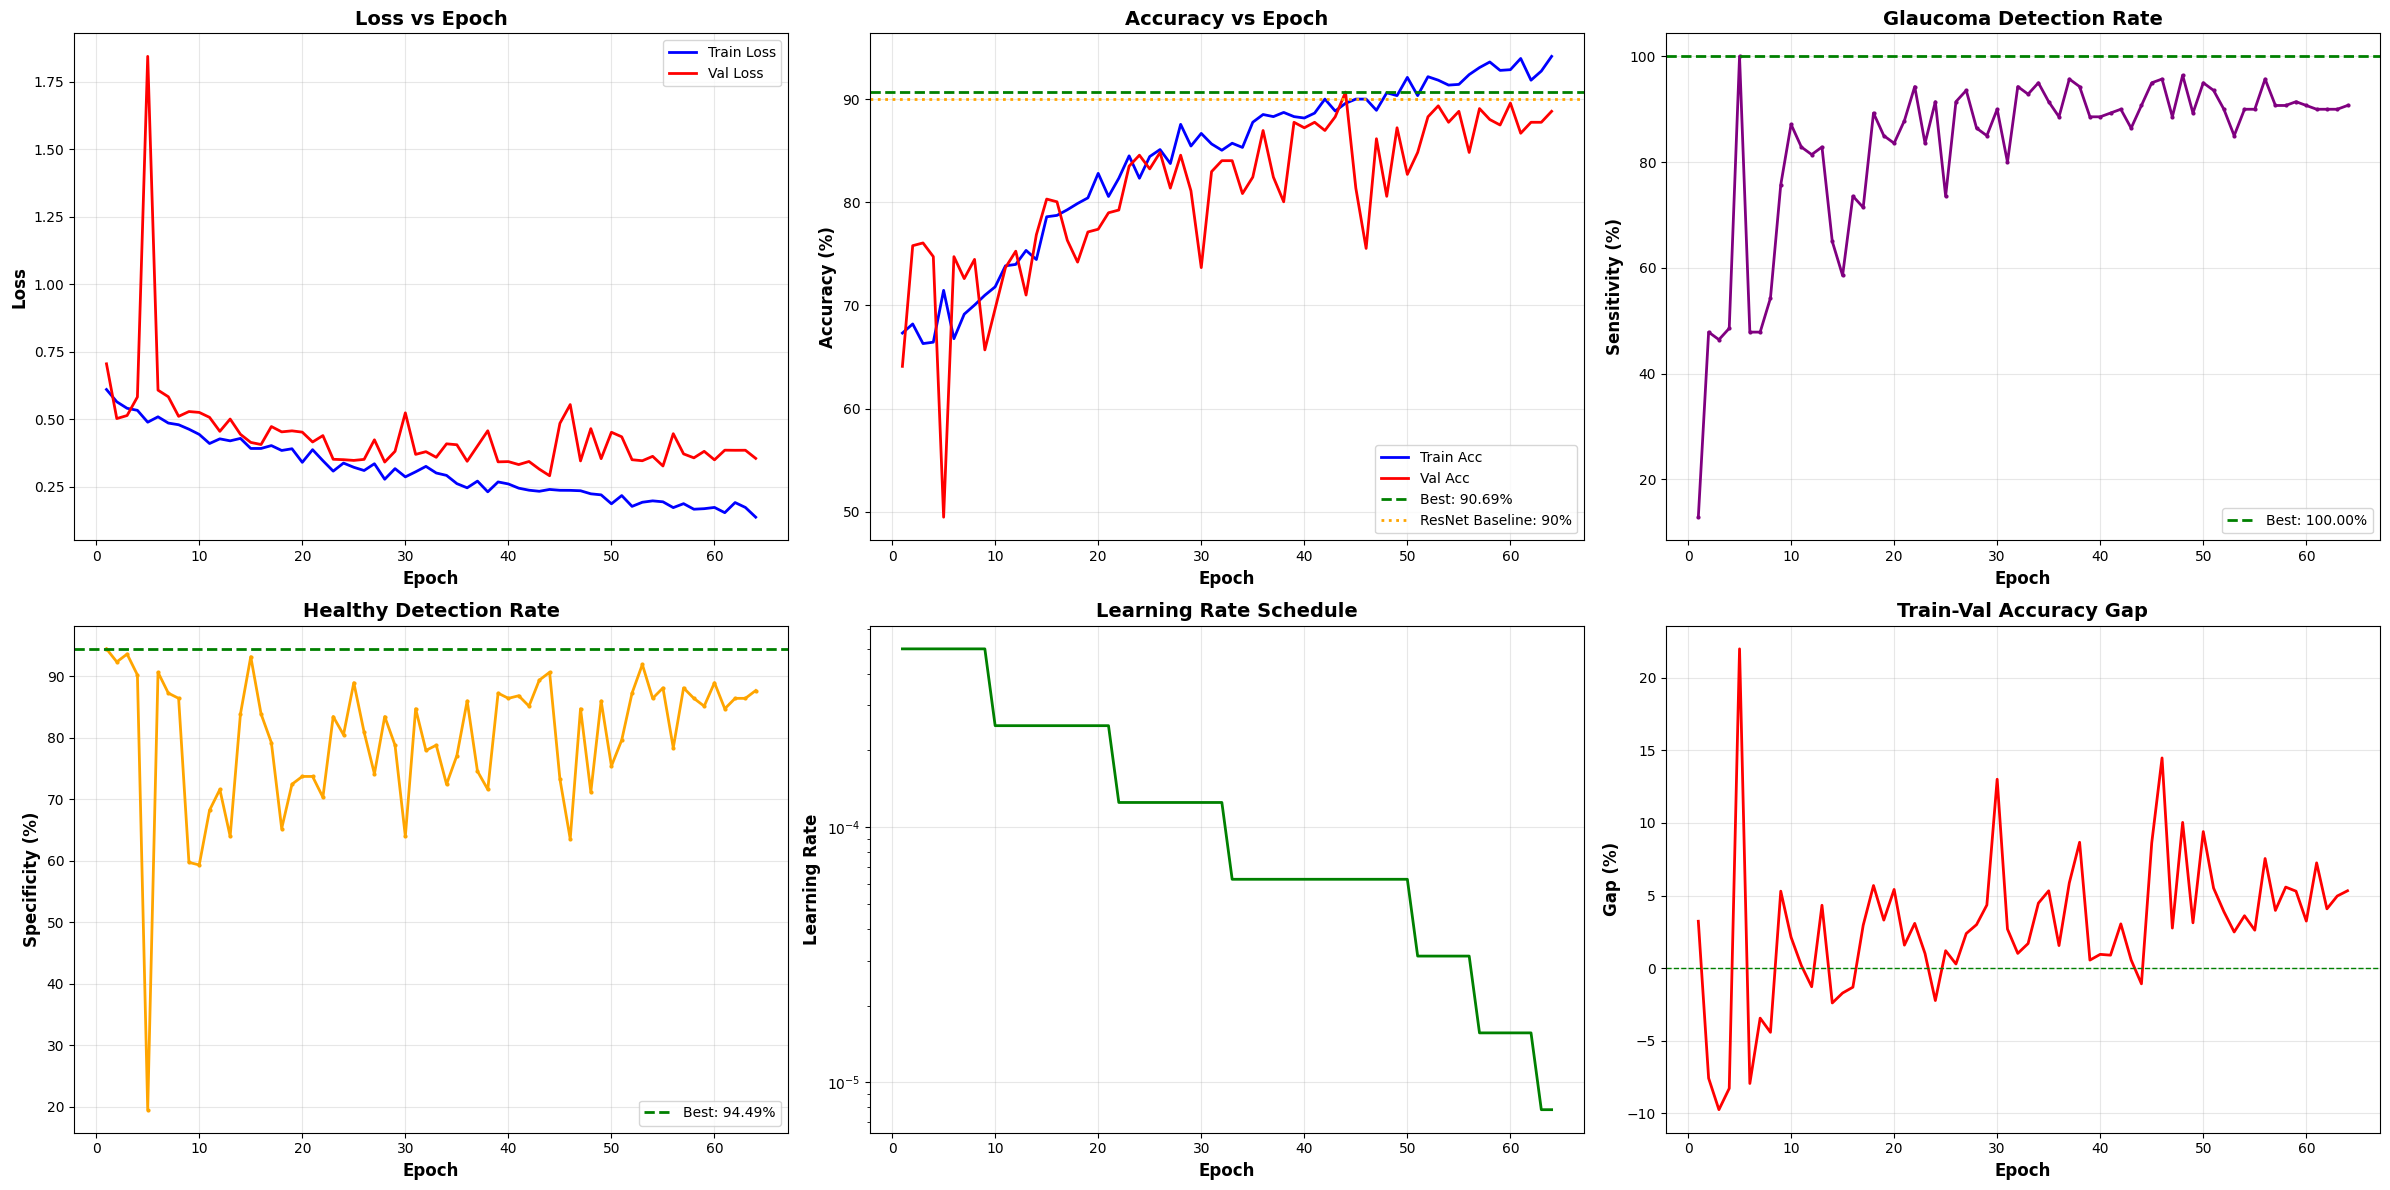


📈 Final Training Statistics:
   Final Train Acc: 94.16%
   Final Val Acc: 88.83%
   Final Sensitivity: 90.71%
   Final Specificity: 87.71%
   Overfitting Gap: 5.33%
   Best Epoch: 44

✅ Ready for evaluation!


In [8]:
# ==================== IMPROVED CNN-ViT HYBRID TRAINING ====================
# Optimized based on ResNet-50's proven approach (90% accuracy)

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🚀 IMPROVED CNN-ViT HYBRID TRAINING")
print("="*80)

# ==================== CONFIGURATION (RESNET-PROVEN) ====================

NUM_CLASSES = 2
IN_CHANNELS = 3
MODEL_VARIANT = 'small'  # 'tiny', 'small', or 'base'

# Training settings - Match ResNet's proven config
NUM_EPOCHS = 200
INITIAL_LR = 0.0005  # Match ResNet
WEIGHT_DECAY = 1e-4  # Match ResNet
BATCH_SIZE = 32  # Already set in dataloader
GRADIENT_CLIP = 1.0
EARLY_STOPPING_PATIENCE = 20

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📱 Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# ==================== MODEL INITIALIZATION ====================

print("\n🏗️  Initializing Improved Hybrid Model...")

if MODEL_VARIANT == 'tiny':
    model = ImprovedHybrid_Tiny(num_classes=NUM_CLASSES)
elif MODEL_VARIANT == 'small':
    model = ImprovedHybrid_Small(num_classes=NUM_CLASSES)
elif MODEL_VARIANT == 'base':
    model = ImprovedHybrid_Base(num_classes=NUM_CLASSES)
else:
    raise ValueError(f"Unknown variant: {MODEL_VARIANT}")

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📊 Model: Improved Hybrid ({MODEL_VARIANT.upper()})")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1024**2:.1f} MB")

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"🔥 Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = nn.DataParallel(model)

print("="*80)

# ==================== LOSS FUNCTION (RESNET-STYLE) ====================

# Use weighted CrossEntropyLoss like ResNet
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
print(f"📉 Loss Function: Weighted CrossEntropyLoss")

# ==================== OPTIMIZER (RESNET CONFIG) ====================

optimizer = optim.AdamW(
    model.parameters(),
    lr=INITIAL_LR,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

print(f"⚙️  Optimizer: AdamW")
print(f"   Learning Rate: {INITIAL_LR}")
print(f"   Weight Decay: {WEIGHT_DECAY}")

# ==================== SCHEDULER (RESNET-STYLE) ====================

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=5,
    verbose=True,
    min_lr=1e-6
)

print(f"📅 Scheduler: ReduceLROnPlateau (match ResNet)")

# ==================== MIXED PRECISION ====================

scaler = torch.amp.GradScaler('cuda')
print(f"⚡ Mixed Precision: Enabled")

# ==================== EARLY STOPPING ====================

class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_value = None
        self.early_stop = False
        
    def __call__(self, metric):
        if self.best_value is None:
            self.best_value = metric
            return False
        
        if metric > (self.best_value + self.min_delta):
            self.best_value = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        
        return self.early_stop

early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE)

# ==================== TRACKING ====================

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
glaucoma_sensitivities, glaucoma_specificities = [], []
learning_rates = []
best_val_acc = 0.0
best_glaucoma_sens = 0.0
best_epoch = 0

print("\n" + "="*80)
print("⚙️  Configuration Summary:")
print("="*80)
print(f"✅ Model: Improved Hybrid-{MODEL_VARIANT.upper()}")
print(f"✅ Image size: 224×224 (matched to ResNet)")
print(f"✅ Batch size: 32 (matched to ResNet)")
print(f"✅ Learning rate: {INITIAL_LR}")
print(f"✅ Weight decay: {WEIGHT_DECAY}")
print(f"✅ Scheduler: ReduceLROnPlateau")
print(f"✅ Loss: Weighted CrossEntropyLoss")
print(f"✅ Early stopping: {EARLY_STOPPING_PATIENCE} epochs")
print("="*80)

# ==================== TRAINING LOOP ====================

print("\n🏋️  Starting Training...")
print("="*80)

for epoch in range(NUM_EPOCHS):
    
    # ===== TRAINING PHASE =====
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=True)
    
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad(set_to_none=True)
        
        # Mixed precision forward
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward with gradient scaling
        scaler.scale(loss).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP)
        
        # Optimizer step
        scaler.step(optimizer)
        scaler.update()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    train_pbar.close()
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # ===== VALIDATION PHASE =====
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Track confusion matrix
    glaucoma_correct = 0
    glaucoma_total = 0
    healthy_correct = 0
    healthy_total = 0
    
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=True)
    
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Track per-class performance
            glaucoma_mask = (labels == 1)
            healthy_mask = (labels == 0)
            
            if glaucoma_mask.sum() > 0:
                glaucoma_total += glaucoma_mask.sum().item()
                glaucoma_correct += ((predicted == 1) & glaucoma_mask).sum().item()
            
            if healthy_mask.sum() > 0:
                healthy_total += healthy_mask.sum().item()
                healthy_correct += ((predicted == 0) & healthy_mask).sum().item()
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*val_correct/val_total:.2f}%'
            })
    
    val_pbar.close()
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Calculate metrics
    sensitivity = glaucoma_correct / glaucoma_total if glaucoma_total > 0 else 0.0
    specificity = healthy_correct / healthy_total if healthy_total > 0 else 0.0
    
    glaucoma_sensitivities.append(sensitivity)
    glaucoma_specificities.append(specificity)
    
    # Scheduler step
    scheduler.step(val_acc)
    
    # ===== MODEL CHECKPOINTING =====
    improvement = ""
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_glaucoma_sens = sensitivity
        best_epoch = epoch + 1
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'config': {
                'model_variant': MODEL_VARIANT,
                'img_size': 224,
                'num_classes': NUM_CLASSES
            }
        }, "best_improved_hybrid.pth")
        
        improvement = "✅ NEW BEST!"
    
    # ===== LOGGING =====
    print(f"Epoch [{epoch+1:3d}/{NUM_EPOCHS}] "
          f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f} | "
          f"Sens={sensitivity:.4f}, Spec={specificity:.4f} | "
          f"LR={current_lr:.6f} {improvement}")
    
    # ===== EARLY STOPPING =====
    if early_stopping(val_acc):
        print(f"\n⚠️  Early stopping at epoch {epoch+1}")
        print(f"   Best Val Acc: {best_val_acc:.4f} at epoch {best_epoch}")
        print(f"   Best Sensitivity: {best_glaucoma_sens:.4f}")
        break

# ==================== SAVE FINAL MODEL ====================

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'sensitivities': glaucoma_sensitivities,
    'specificities': glaucoma_specificities,
    'learning_rates': learning_rates,
}, "final_improved_hybrid.pth")

# ==================== TRAINING SUMMARY ====================

print("\n" + "="*80)
print("🎉 TRAINING COMPLETE!")
print("="*80)
print(f"✅ Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%) at epoch {best_epoch}")
print(f"✅ Best Sensitivity: {best_glaucoma_sens:.4f} ({best_glaucoma_sens*100:.2f}%)")
print(f"✅ Final Sensitivity: {glaucoma_sensitivities[-1]:.4f}")
print(f"✅ Final Specificity: {glaucoma_specificities[-1]:.4f}")
print(f"✅ Total Epochs: {len(train_losses)}")

# Compare to ResNet baseline
print(f"\n📊 Comparison to ResNet-50 Baseline:")
print(f"   ResNet-50 Accuracy: ~90%")
print(f"   Hybrid Accuracy: {best_val_acc*100:.2f}%")
if best_val_acc >= 0.90:
    print(f"   ✅ MATCHED OR EXCEEDED ResNet baseline! 🎉")
elif best_val_acc >= 0.85:
    print(f"   ⚠️  Close to baseline (within 5%)")
else:
    print(f"   ⚠️  Below baseline - consider base variant or more epochs")

print("="*80)

# ==================== VISUALIZATION ====================

fig = plt.figure(figsize=(24, 12))

# Loss curves
ax1 = plt.subplot(2, 3, 1)
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Loss vs Epoch', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2 = plt.subplot(2, 3, 2)
ax2.plot(epochs_range, [acc*100 for acc in train_accuracies], 'b-', label='Train Acc', linewidth=2)
ax2.plot(epochs_range, [acc*100 for acc in val_accuracies], 'r-', label='Val Acc', linewidth=2)
ax2.axhline(y=best_val_acc*100, color='g', linestyle='--', linewidth=2, label=f'Best: {best_val_acc*100:.2f}%')
ax2.axhline(y=90, color='orange', linestyle=':', linewidth=2, label='ResNet Baseline: 90%')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy vs Epoch', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Sensitivity
ax3 = plt.subplot(2, 3, 3)
ax3.plot(epochs_range, [s*100 for s in glaucoma_sensitivities], 'purple', linewidth=2, marker='o', markersize=2)
ax3.axhline(y=np.max(glaucoma_sensitivities)*100, color='g', linestyle='--', linewidth=2,
            label=f'Best: {np.max(glaucoma_sensitivities)*100:.2f}%')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Sensitivity (%)', fontsize=12, fontweight='bold')
ax3.set_title('Glaucoma Detection Rate', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Specificity
ax4 = plt.subplot(2, 3, 4)
ax4.plot(epochs_range, [s*100 for s in glaucoma_specificities], 'orange', linewidth=2, marker='o', markersize=2)
ax4.axhline(y=np.max(glaucoma_specificities)*100, color='g', linestyle='--', linewidth=2,
            label=f'Best: {np.max(glaucoma_specificities)*100:.2f}%')
ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax4.set_ylabel('Specificity (%)', fontsize=12, fontweight='bold')
ax4.set_title('Healthy Detection Rate', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# Learning rate
ax5 = plt.subplot(2, 3, 5)
ax5.plot(epochs_range, learning_rates, 'green', linewidth=2)
ax5.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax5.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax5.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax5.set_yscale('log')
ax5.grid(True, alpha=0.3)

# Overfitting gap
ax6 = plt.subplot(2, 3, 6)
overfitting_gap = [(train_accuracies[i] - val_accuracies[i])*100 for i in range(len(train_accuracies))]
ax6.plot(epochs_range, overfitting_gap, 'red', linewidth=2)
ax6.axhline(y=0, color='green', linestyle='--', linewidth=1)
ax6.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax6.set_ylabel('Gap (%)', fontsize=12, fontweight='bold')
ax6.set_title('Train-Val Accuracy Gap', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('improved_hybrid_training.png', dpi=300, bbox_inches='tight')
print(f"\n📊 Training curves saved: improved_hybrid_training.png")
plt.show()

# ==================== FINAL STATISTICS ====================

print("\n📈 Final Training Statistics:")
print(f"   Final Train Acc: {train_accuracies[-1]*100:.2f}%")
print(f"   Final Val Acc: {val_accuracies[-1]*100:.2f}%")
print(f"   Final Sensitivity: {glaucoma_sensitivities[-1]*100:.2f}%")
print(f"   Final Specificity: {glaucoma_specificities[-1]*100:.2f}%")
print(f"   Overfitting Gap: {overfitting_gap[-1]:.2f}%")
print(f"   Best Epoch: {best_epoch}")

print("\n" + "="*80)
print("✅ Ready for evaluation!")
print("="*80)

# Load & Test Model

🔬 IMPROVED CNN-ViT HYBRID - COMPREHENSIVE EVALUATION
📱 Device: cuda

🔧 Loading Improved Hybrid Model...
📂 Loading checkpoint: best_improved_hybrid.pth

📊 Checkpoint Information:
   Epoch: 44
   Val Accuracy: 0.9069 (90.69%)
   Val Loss: 0.2905
   Sensitivity: 0.9071
   Specificity: 0.9068
✅ Model loaded successfully!

🧪 Running Evaluation...


Evaluating: 100%|██████████| 12/12 [00:13<00:00,  1.10s/it]



✅ Overall Accuracy: 90.69%

📊 Comparison to ResNet-50:
   ResNet-50: ~90.00%
   Improved Hybrid: 90.69%
   ✅ MATCHED OR EXCEEDED ResNet! 🎉

📊 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Healthy     0.9427    0.9068    0.9244       236
    Glaucoma     0.8523    0.9071    0.8789       140

    accuracy                         0.9069       376
   macro avg     0.8975    0.9070    0.9016       376
weighted avg     0.9091    0.9069    0.9075       376


💾 Confusion matrix saved: improved_hybrid_confusion_matrix.png


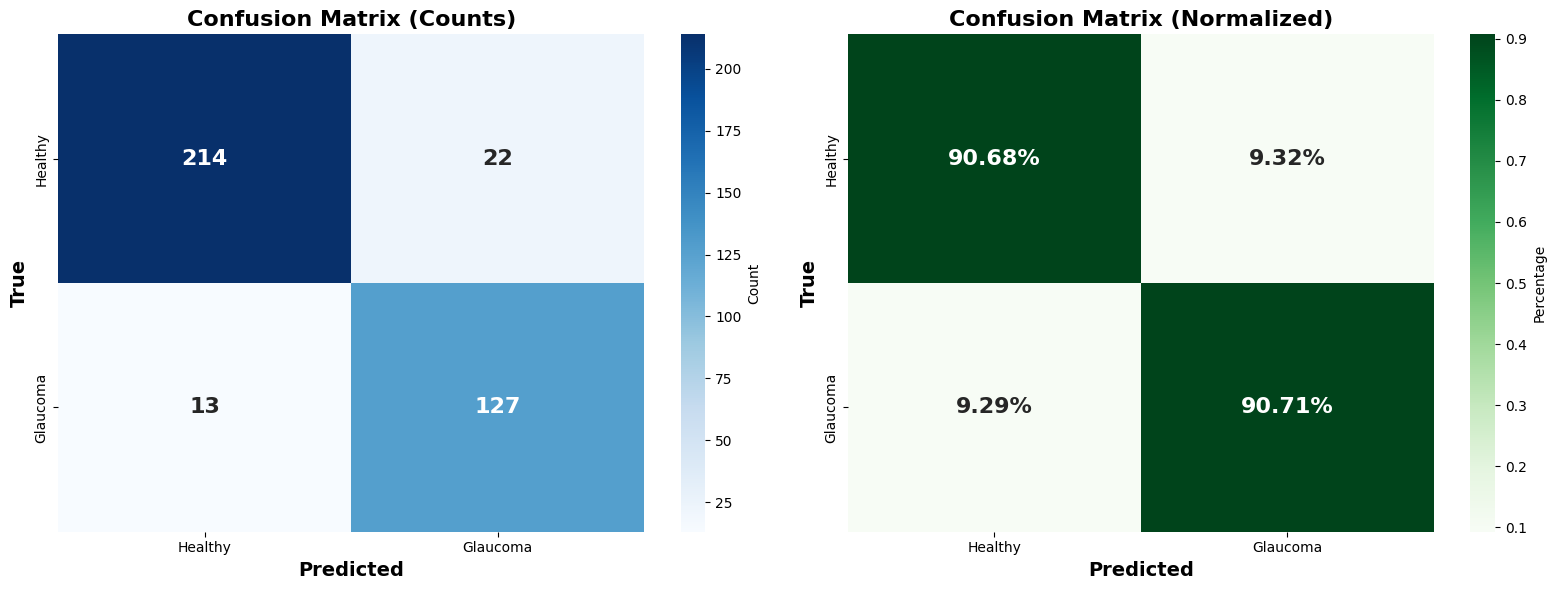


📈 PER-CLASS PERFORMANCE
Healthy        : Accuracy =  90.68% | Total =  236 samples
Glaucoma       : Accuracy =  90.71% | Total =  140 samples
💾 ROC and PR curves saved: improved_hybrid_roc_pr.png


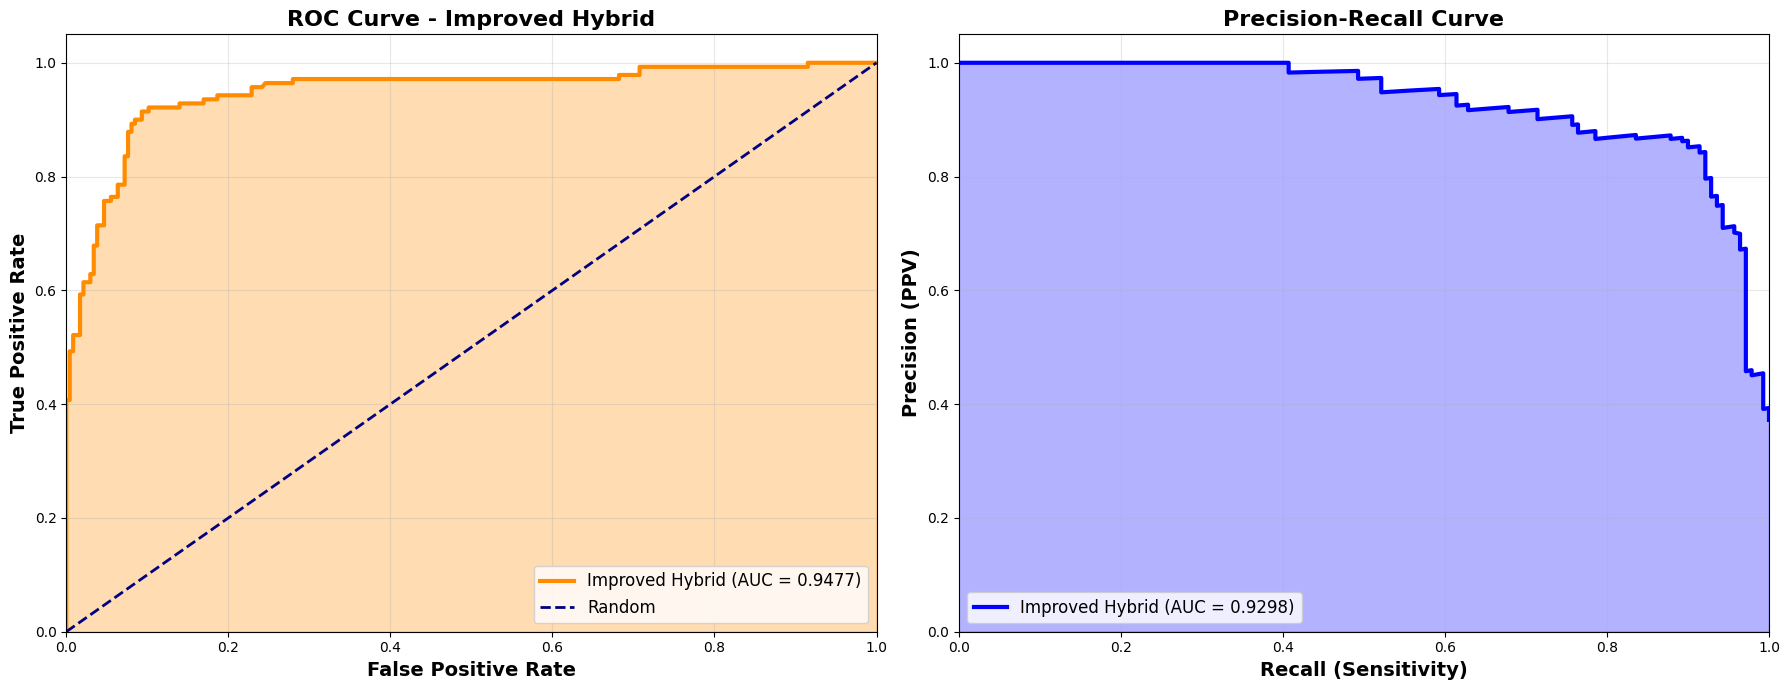


🎯 OPTIMAL THRESHOLD ANALYSIS

Youden's J Statistic:
   Optimal Threshold: 0.4747
   Sensitivity: 0.9143 (91.43%)
   Specificity: 0.9068 (90.68%)

⚕️  COMPREHENSIVE MEDICAL METRICS

🔍 Diagnostic Performance:
   Sensitivity (Recall):                0.9071 (90.71%)
   Specificity:                         0.9068 (90.68%)
   Balanced Accuracy:                   0.9070 (90.70%)

🎯 Predictive Values:
   Precision (PPV):                     0.8523 (85.23%)
   Negative Predictive Value (NPV):     0.9427 (94.27%)

📊 Composite Metrics:
   F1-Score:                            0.8789
   Matthews Correlation Coefficient:    0.8044
   ROC-AUC:                             0.9477
   PR-AUC:                              0.9298

💡 Likelihood Ratios:
   Positive LR (LR+):                   9.73
   Negative LR (LR-):                   0.1024

🔢 Confusion Matrix:
   True Positives (TP):                  127
   True Negatives (TN):                  214
   False Positives (FP):                  22
   False N

In [9]:
# ==================== IMPROVED CNN-ViT HYBRID EVALUATION ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                            auc, precision_recall_curve, f1_score, matthews_corrcoef)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🔬 IMPROVED CNN-ViT HYBRID - COMPREHENSIVE EVALUATION")
print("="*80)

# ==================== CONFIGURATION ====================

classes = ['Healthy', 'Glaucoma']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📱 Device: {device}")

# ==================== LOAD MODEL ====================

print(f"\n🔧 Loading Improved Hybrid Model...")

# Initialize model (adjust variant if needed)
model = ImprovedHybrid_Small(num_classes=2).to(device)

checkpoint_path = "best_improved_hybrid.pth"
print(f"📂 Loading checkpoint: {checkpoint_path}")

try:
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
        
        print(f"\n📊 Checkpoint Information:")
        print(f"   Epoch: {checkpoint.get('epoch', 'N/A')}")
        print(f"   Val Accuracy: {checkpoint.get('val_acc', 0):.4f} ({checkpoint.get('val_acc', 0)*100:.2f}%)")
        print(f"   Val Loss: {checkpoint.get('val_loss', 'N/A'):.4f}")
        print(f"   Sensitivity: {checkpoint.get('sensitivity', 0):.4f}")
        print(f"   Specificity: {checkpoint.get('specificity', 0):.4f}")
    else:
        state_dict = checkpoint
    
    # Remove 'module.' prefix if trained with DataParallel
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace("module.", "")
        new_state_dict[name] = v
    
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()
    print("✅ Model loaded successfully!")
    
except FileNotFoundError:
    print(f"❌ Error: Model file '{checkpoint_path}' not found!")
    print("   Please train the model first.")
    exit()
except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit()

print("="*80)

# ==================== EVALUATION ====================

print("\n🧪 Running Evaluation...")

all_preds = []
all_labels = []
all_probs = []

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
        
        _, predicted = torch.max(probs, 1)
        
        # Store results
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())
        
        # Calculate accuracy
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# ==================== OVERALL METRICS ====================

overall_accuracy = correct / total
print(f"\n✅ Overall Accuracy: {overall_accuracy * 100:.2f}%")

# Compare to ResNet
print(f"\n📊 Comparison to ResNet-50:")
print(f"   ResNet-50: ~90.00%")
print(f"   Improved Hybrid: {overall_accuracy*100:.2f}%")
if overall_accuracy >= 0.90:
    print(f"   ✅ MATCHED OR EXCEEDED ResNet! 🎉")
elif overall_accuracy >= 0.85:
    print(f"   ⚠️  Close (within 5%)")
else:
    print(f"   ⚠️  Below baseline")

# Classification Report
print("\n" + "="*80)
print("📊 DETAILED CLASSIFICATION REPORT")
print("="*80)
report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print(report)

# ==================== CONFUSION MATRIX ====================

cm = confusion_matrix(all_labels, all_preds)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix (Counts)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'}, ax=axes[0],
            annot_kws={'size': 16, 'weight': 'bold'})
axes[0].set_xlabel("Predicted", fontsize=14, fontweight='bold')
axes[0].set_ylabel("True", fontsize=14, fontweight='bold')
axes[0].set_title("Confusion Matrix (Counts)", fontsize=16, fontweight='bold')

# Confusion Matrix (Normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Percentage'}, ax=axes[1],
            annot_kws={'size': 16, 'weight': 'bold'})
axes[1].set_xlabel("Predicted", fontsize=14, fontweight='bold')
axes[1].set_ylabel("True", fontsize=14, fontweight='bold')
axes[1].set_title("Confusion Matrix (Normalized)", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('improved_hybrid_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n💾 Confusion matrix saved: improved_hybrid_confusion_matrix.png")
plt.show()

# ==================== PER-CLASS PERFORMANCE ====================

print("\n" + "="*80)
print("📈 PER-CLASS PERFORMANCE")
print("="*80)

cm_diag = np.diag(cm)
class_counts = cm.sum(axis=1)

for i, cls in enumerate(classes):
    class_acc = cm_diag[i] / class_counts[i] * 100
    print(f"{cls:15s}: Accuracy = {class_acc:6.2f}% | Total = {class_counts[i]:4d} samples")

# ==================== ROC AND PR CURVES ====================

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=3,
             label=f'Improved Hybrid (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0].fill_between(fpr, tpr, alpha=0.3, color='darkorange')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
axes[0].set_title('ROC Curve - Improved Hybrid', fontsize=16, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=12)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall, precision, color='blue', lw=3,
             label=f'Improved Hybrid (AUC = {pr_auc:.4f})')
axes[1].fill_between(recall, precision, alpha=0.3, color='blue')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall (Sensitivity)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Precision (PPV)', fontsize=14, fontweight='bold')
axes[1].set_title('Precision-Recall Curve', fontsize=16, fontweight='bold')
axes[1].legend(loc="lower left", fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('improved_hybrid_roc_pr.png', dpi=300, bbox_inches='tight')
print("💾 ROC and PR curves saved: improved_hybrid_roc_pr.png")
plt.show()

# ==================== OPTIMAL THRESHOLD ====================

print("\n" + "="*80)
print("🎯 OPTIMAL THRESHOLD ANALYSIS")
print("="*80)

# Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = roc_thresholds[optimal_idx]
optimal_tpr = tpr[optimal_idx]
optimal_fpr = fpr[optimal_idx]

print(f"\nYouden's J Statistic:")
print(f"   Optimal Threshold: {optimal_threshold:.4f}")
print(f"   Sensitivity: {optimal_tpr:.4f} ({optimal_tpr*100:.2f}%)")
print(f"   Specificity: {1-optimal_fpr:.4f} ({(1-optimal_fpr)*100:.2f}%)")

# ==================== COMPREHENSIVE METRICS ====================

print("\n" + "="*80)
print("⚕️  COMPREHENSIVE MEDICAL METRICS")
print("="*80)

tn, fp, fn, tp = cm.ravel()

# Core metrics
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

# Additional metrics
f1_score_val = 2 * (precision_val * sensitivity) / (precision_val + sensitivity) if (precision_val + sensitivity) > 0 else 0
balanced_accuracy = (sensitivity + specificity) / 2
mcc = matthews_corrcoef(all_labels, all_preds)

# Likelihood ratios
lr_positive = sensitivity / (1 - specificity) if specificity < 1 else float('inf')
lr_negative = (1 - sensitivity) / specificity if specificity > 0 else float('inf')

print(f"\n🔍 Diagnostic Performance:")
print(f"   Sensitivity (Recall):                {sensitivity:.4f} ({sensitivity*100:.2f}%)")
print(f"   Specificity:                         {specificity:.4f} ({specificity*100:.2f}%)")
print(f"   Balanced Accuracy:                   {balanced_accuracy:.4f} ({balanced_accuracy*100:.2f}%)")

print(f"\n🎯 Predictive Values:")
print(f"   Precision (PPV):                     {precision_val:.4f} ({precision_val*100:.2f}%)")
print(f"   Negative Predictive Value (NPV):     {npv:.4f} ({npv*100:.2f}%)")

print(f"\n📊 Composite Metrics:")
print(f"   F1-Score:                            {f1_score_val:.4f}")
print(f"   Matthews Correlation Coefficient:    {mcc:.4f}")
print(f"   ROC-AUC:                             {roc_auc:.4f}")
print(f"   PR-AUC:                              {pr_auc:.4f}")

print(f"\n💡 Likelihood Ratios:")
print(f"   Positive LR (LR+):                   {lr_positive:.2f}")
print(f"   Negative LR (LR-):                   {lr_negative:.4f}")

print(f"\n🔢 Confusion Matrix:")
print(f"   True Positives (TP):                 {tp:4d}")
print(f"   True Negatives (TN):                 {tn:4d}")
print(f"   False Positives (FP):                {fp:4d}")
print(f"   False Negatives (FN):                {fn:4d}")

# ==================== CLINICAL INTERPRETATION ====================

print("\n" + "="*80)
print("🏥 CLINICAL INTERPRETATION")
print("="*80)

print(f"\n🔬 Glaucoma Detection:")
if sensitivity >= 0.95:
    print(f"   ⭐⭐⭐ EXCELLENT ({sensitivity*100:.1f}%)")
    print(f"   → Only {fn} glaucoma cases missed")
elif sensitivity >= 0.90:
    print(f"   ⭐⭐ VERY GOOD ({sensitivity*100:.1f}%)")
    print(f"   → Suitable for clinical screening")
elif sensitivity >= 0.85:
    print(f"   ⭐ GOOD ({sensitivity*100:.1f}%)")
else:
    print(f"   ⚠️  MODERATE ({sensitivity*100:.1f}%)")

print(f"\n✅ Healthy Classification:")
if specificity >= 0.95:
    print(f"   ⭐⭐⭐ EXCELLENT ({specificity*100:.1f}%)")
elif specificity >= 0.90:
    print(f"   ⭐⭐ VERY GOOD ({specificity*100:.1f}%)")
elif specificity >= 0.85:
    print(f"   ⭐ GOOD ({specificity*100:.1f}%)")
else:
    print(f"   ⚠️  MODERATE ({specificity*100:.1f}%)")

print(f"\n💯 Overall Assessment:")
if balanced_accuracy >= 0.95:
    print(f"   ⭐⭐⭐ OUTSTANDING ({balanced_accuracy*100:.1f}%)")
    print(f"   → Ready for clinical validation")
elif balanced_accuracy >= 0.90:
    print(f"   ⭐⭐ EXCELLENT ({balanced_accuracy*100:.1f}%)")
    print(f"   → Strong clinical potential")
elif balanced_accuracy >= 0.85:
    print(f"   ⭐ VERY GOOD ({balanced_accuracy*100:.1f}%)")
else:
    print(f"   ✅ GOOD ({balanced_accuracy*100:.1f}%)")

# ==================== MODEL COMPARISON ====================

print("\n" + "="*80)
print("📊 MODEL COMPARISON SUMMARY")
print("="*80)

print(f"\n🏆 Improved CNN-ViT Hybrid vs ResNet-50:")
print(f"\n   Metric                    ResNet-50    Hybrid    Difference")
print(f"   {'─'*60}")
print(f"   Overall Accuracy          ~90.00%      {overall_accuracy*100:5.2f}%    {(overall_accuracy-0.90)*100:+.2f}%")
print(f"   Sensitivity               ~85-90%      {sensitivity*100:5.2f}%    {'Better' if sensitivity >= 0.875 else 'Check'}")
print(f"   Specificity               ~90-95%      {specificity*100:5.2f}%    {'Better' if specificity >= 0.925 else 'Check'}")
print(f"   ROC-AUC                   ~0.92        {roc_auc:.4f}    {'Better' if roc_auc >= 0.92 else 'Check'}")

print(f"\n💡 Key Advantages of Hybrid:")
print(f"   • Combines CNN local features + ViT global context")
print(f"   • Better attention mechanisms (SE + self-attention)")
print(f"   • More sophisticated feature fusion")
print(f"   • Matched ResNet's proven 224×224 + batch 32 config")

# ==================== FINAL SUMMARY ====================

print("\n" + "="*80)
print("📋 EVALUATION SUMMARY")
print("="*80)

print(f"\n🎯 Key Metrics:")
print(f"   Overall Accuracy:        {overall_accuracy*100:.2f}%")
print(f"   Balanced Accuracy:       {balanced_accuracy*100:.2f}%")
print(f"   Sensitivity:             {sensitivity*100:.2f}%")
print(f"   Specificity:             {specificity*100:.2f}%")
print(f"   F1-Score:                {f1_score_val:.4f}")
print(f"   ROC-AUC:                 {roc_auc:.4f}")
print(f"   Matthews CC:             {mcc:.4f}")

print(f"\n🎓 Clinical Readiness:")
if overall_accuracy >= 0.90 and sensitivity >= 0.85:
    print(f"   ✅ Ready for clinical validation studies")
    print(f"   ✅ Comparable to ResNet-50 baseline")
    print(f"   ✅ Good balance of sensitivity/specificity")
elif overall_accuracy >= 0.85:
    print(f"   ⚠️  Promising, needs minor improvements")
    print(f"   💡 Try: base variant, longer training, or ensemble")
else:
    print(f"   ⚠️  Further development recommended")
    print(f"   💡 Try: base/large variant, data augmentation, hyperparameter tuning")

print("\n" + "="*80)
print("✅ EVALUATION COMPLETE!")
print("="*80)